# LIBD heterogeneity

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/jovyan/work/code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from gradientVersion import *
from pcaVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


In [233]:
exp = pd.read_csv("../data/libd.csv", index_col=0)

In [234]:
exp

,ENSG00000227232.5,ENSG00000278267.1,ENSG00000279457.3,ENSG00000228463.9,ENSG00000236679.2,ENSG00000225972.1,ENSG00000225630.1,ENSG00000237973.1,ENSG00000229344.1,ENSG00000248527.1,...,ENSG00000067048.16,ENSG00000183878.15,ENSG00000215414.4,ENSG00000241859.6,ENSG00000165246.12,ENSG00000176728.7,ENSG00000185275.6,ENSG00000131002.11,ENSG00000012817.15,ENSG00000198692.9
BrNum,,,,,,,,,,,,,,,,,,,,,
Br5168,0.731495,1.309724,-1.389818,-0.299747,0.576257,1.418600,-1.380476,-2.247093,-1.559466,-1.609708,...,-1.045124,-0.567825,-1.957071,-1.129146,-0.518045,-0.518045,2.129627,-1.082954,-0.251407,-0.694568
Br5073,0.750336,-0.156348,0.001790,0.341201,-2.129627,1.362144,0.864412,0.518045,-2.673907,0.218288,...,-1.129146,-1.512878,2.347068,0.091407,0.798654,0.091407,-0.080629,-1.438460,-0.745601,-0.991030
Br5217,-0.526250,-1.344259,0.170860,-0.690019,-0.685485,0.203647,0.699132,-0.658565,0.818509,0.505802,...,0.255103,-0.174493,0.593246,-1.177883,-0.348799,0.375555,0.465524,0.939691,1.014705,-0.044760
Br5234,1.192332,0.080629,-0.584730,0.563625,0.055513,0.690019,0.055513,-0.680964,-1.438460,0.051928,...,0.694568,0.016109,2.129627,-0.441718,0.429909,-0.207303,-0.375555,0.156348,0.509875,0.906800
Br5372,0.023270,0.341201,0.864412,0.950883,1.957071,-1.571658,1.214485,1.636431,1.571658,1.389818,...,-0.149105,0.364057,0.522143,-0.627750,-0.703709,-0.485564,-0.112998,-0.221956,0.465524,0.163600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Br2285.1,-0.481541,0.979399,-0.606100,-0.497683,1.163676,0.134641,-0.597519,-0.546919,-0.576257,-0.333622,...,-0.229299,1.008733,-1.596767,1.888883,0.685485,0.833614,-1.135944,-0.485564,0.708302,-0.080629
Br2288.1,-0.185407,-1.584087,-0.269924,0.087813,-0.699132,-1.847879,0.174493,-0.717533,-1.724528,-1.380476,...,-0.170860,0.449625,1.353147,1.828491,0.509875,0.422070,-0.542767,0.145486,-1.740584,0.218288
Br873,0.044760,0.429909,1.207035,-0.854056,-0.779109,-0.667485,-1.636431,-0.676457,0.429909,-1.199651,...,1.192332,0.303494,-0.477525,-1.076542,-1.828491,-1.740584,-0.493635,1.156659,0.619055,1.724528


In [235]:
def ensembl_id_to_gene_symbol(ensembl_ids):
    mg = mygene.MyGeneInfo()
    ensembl_ids = [ens.split('.')[0] for ens in ensembl_ids]
    matches = mg.querymany(ensembl_ids, scopes='ensembl.gene', as_dataframe=True)
    return(matches)

matches = ensembl_id_to_gene_symbol(exp.columns)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-20832...done.
Finished.
2 input query terms found dup hits:
	[('ENSG00000260788', 2), ('ENSG00000229425', 2)]
312 input query terms found no hit:
	['ENSG00000236269', 'ENSG00000271895', 'ENSG00000225986', 'ENSG00000271840', 'ENSG00000116883', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [236]:
exp_clean = (exp
.transpose()
.assign(ensembl_id = lambda x: [ens.split('.')[0] for ens in x.index]).set_index('ensembl_id')
.join(matches['symbol']).set_index('symbol')
.loc[lambda x: x.index.notnull()]
.loc[lambda x: ~x.index.duplicated()]
.transpose()
)
exp_clean

symbol,TSPAN6,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,LINC01902,MIR7157,MIR3975,MIR4317,MIR376B,MIR376A2,LOC124904687,MIR338,LOC729732,MIR5087
Br5168,-2.065088,0.736181,0.663018,1.344259,1.344259,0.555253,-1.650243,-1.847879,1.149699,-1.135944,...,0.196344,1.095913,-1.957071,-0.030431,-1.399284,2.294219,2.830936,-0.189050,-0.636492,-0.779109
Br5073,-0.708302,-0.292267,-0.322290,-1.192332,0.005369,-0.530365,-0.383249,0.236656,-1.847879,0.203647,...,0.303494,-0.221956,-0.141869,-0.055513,0.619055,-1.650243,0.680964,0.116601,2.204486,-1.335475
Br5217,0.623397,0.037595,1.177883,-1.122400,-0.019689,-0.465524,-0.134641,0.189050,0.281078,-0.059098,...,-0.580489,0.890717,0.383249,0.567825,-0.145486,1.389818,0.551081,-0.255103,-0.736181,-0.501738
Br5234,0.572036,-0.567825,-0.485564,-1.032842,0.322290,-1.102463,0.610407,0.576257,0.489596,-0.597519,...,-0.123812,0.869625,1.020713,0.425986,-0.102197,1.051324,0.779109,0.680964,0.051928,-1.490766
Br5372,-0.299747,1.229591,0.310999,-0.277356,0.262506,-0.703709,0.973632,0.098599,-0.783967,0.414257,...,0.818509,1.199651,0.402584,-0.352606,-0.360234,-1.867989,-0.680964,0.102197,-0.299747,0.917653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Br2285.1,-0.917653,-1.170750,-0.163600,-1.418600,0.601804,1.038963,-0.934139,-0.127420,-1.584087,-2.830936,...,1.115705,0.123812,1.335475,0.493635,-1.428460,1.693686,-1.014705,1.032842,1.063848,-0.364057
Br2288.1,-0.410359,-0.526250,-0.717533,-1.207035,0.572036,-0.016109,0.322290,0.934139,1.070173,0.736181,...,0.134641,-0.178129,-2.830936,1.089411,1.678851,-0.127420,-0.284804,-0.991030,-1.122400,-0.917653
Br873,1.177883,-1.559466,-0.606100,1.408876,-0.880122,-1.399284,1.102463,-1.163676,1.571658,2.165541,...,-0.546919,-0.685485,-1.809766,-1.362144,2.247093,0.708302,0.956524,-0.973632,-2.407420,0.203647
Br1884.1,-0.218288,2.673907,0.189050,0.703709,0.174493,0.105796,-0.080629,1.479979,-0.694568,0.394832,...,-0.425986,0.580489,0.808541,0.956524,0.505802,-1.115705,1.490766,-2.830936,0.534490,2.830936


## Convert to G1-3

In [219]:
# dme_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
weights = dme_3d_ds5.weights.iloc[:,:3].set_axis(['G1','G2','G3'], axis=1)

In [244]:
weights_pos

,G1,G2,G3
A1BG,0.000000,0.000000,0.000697
A1BG-AS1,0.000000,0.000000,0.000000
AAAS,0.011610,0.004924,0.002747
AAED1,0.000000,0.000000,0.008323
AAGAB,0.000000,0.019885,0.000000
...,...,...,...
ZSWIM9,0.000000,0.000471,0.002507
ZWINT,0.000000,0.000000,0.000573
ZYX,0.017013,0.005948,0.000000
ZZEF1,0.013004,0.000000,0.009700


In [254]:
matched_genes = np.intersect1d(exp_clean.columns, weights.index)
exp_matched = exp_clean.loc[:, matched_genes]

weights_pos = weights.apply(lambda x: np.where(x>0,x,0))
weights_neg = weights.apply(lambda x: np.where(x<0,x,0))

exp_projected = exp_matched @ weights.loc[matched_genes, :]
exp_projected

,G1,G2,G3
Br5168,-16.464502,-8.268194,-1.943297
Br5073,0.905313,10.254684,4.029744
Br5217,3.528584,13.944556,7.173356
Br5234,-0.129323,10.947351,7.203183
Br5372,-2.367832,-4.343988,-2.664706
...,...,...,...
Br2285.1,8.844439,-7.109784,-0.733325
Br2288.1,2.004275,11.055687,11.568738
Br873,-7.131887,4.514156,-11.217680
Br1884.1,15.197411,9.225569,6.078736


In [189]:
clinical = pd.read_csv("../data/libd_clinical_data.csv").assign(id=lambda x: ['Br'+str(b) for b in x['Br#']]).set_index('id')

In [222]:
np.intersect1d(clinical.index, exp_projected.index.str.replace('\..','')).shape

/tmp/ipykernel_72574/2262356337.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  np.intersect1d(clinical.index, exp_projected.index.str.replace('\..','')).shape


(160,)

In [255]:
exp_join = (exp_projected
    .assign(BrNum = lambda x: x.index.str.replace('\..',''))
    .join(clinical, on='BrNum')
    .assign(PastSI = lambda x: np.where(np.isin(x['Past SI'], ['Yes','yes']),'Yes','No/Unknown'))
    .assign(PastSA = lambda x: np.where(np.isin(x['Past Suicide Attempts'], [0, None, 'None', 'Unknown', 'NA']),'No/Unknown','Yes'))
)
exp_join

/tmp/ipykernel_72574/934960429.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  .assign(BrNum = lambda x: x.index.str.replace('\..',''))


,G1,G2,G3,BrNum,Br#,AgeDeath,Source,Sex,Race,Smoking,...,Age Onset Substance,Last Medications,Lifetime Antipsych,Lifetime Anticonvulsant,Lifetime Antidepress,Lifetime Lithium,Past Suicide Attempts,Past SI,PastSI,PastSA
Br5168,-16.464502,-8.268194,-1.943297,Br5168,5168,64.1,LIBD ME,M,CAUC,No,...,NaN,No psych meds,No,No,No,No,0,No,No/Unknown,Yes
Br5073,0.905313,10.254684,4.029744,Br5073,5073,62.6,LIBD ME,M,AA,Yes,...,NaN,"Haldol, Lithium Carbonate 300, Cogentin 1 @ TOD",Yes,Yes,Not Filled in,Yes,0,Yes,Yes,Yes
Br5217,3.528584,13.944556,7.173356,Br5217,5217,30.0,LIBD ME,M,CAUC,No,...,NaN,Risperdal 2 5/13,Yes,No,Yes,No,2,Yes,Yes,Yes
Br5234,-0.129323,10.947351,7.203183,Br5234,5234,65.3,LIBD ME,M,CAUC,Yes,...,NaN,Chlorpromazine @ TOD per records; Chlorpromazi...,Yes,No,No,No,None,Yes,Yes,No/Unknown
Br5372,-2.367832,-4.343988,-2.664706,Br5372,5372,32.4,LIBD ME,M,AA,Yes,...,NaN,"Haldol 20 qhs, Hayldol IM 200 (frequency UK) @...",Yes,Yes,No,No,1,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Br2285.1,8.844439,-7.109784,-0.733325,Br2285,2285,53.3,NIMH,M,CAUC,No,...,NaN,Naproxen,No,No,No,No,None,No,No/Unknown,No/Unknown
Br2288.1,2.004275,11.055687,11.568738,Br2288,2288,44.7,NIMH,M,CAUC,No,...,NaN,none,No,No,No,No,None,No,No/Unknown,No/Unknown
Br873,-7.131887,4.514156,-11.217680,Br873,873,59.5,NIMH,F,AA,No,...,NaN,"Haldol 2 QID, Haldol Decanoate 70 mg IM q 4 we...",Yes,No,No,No,1,Yes,Yes,Yes
Br1884.1,15.197411,9.225569,6.078736,Br1884,1884,38.5,NIMH,M,AA,No,...,NaN,none,No,No,No,No,None,No,No/Unknown,No/Unknown


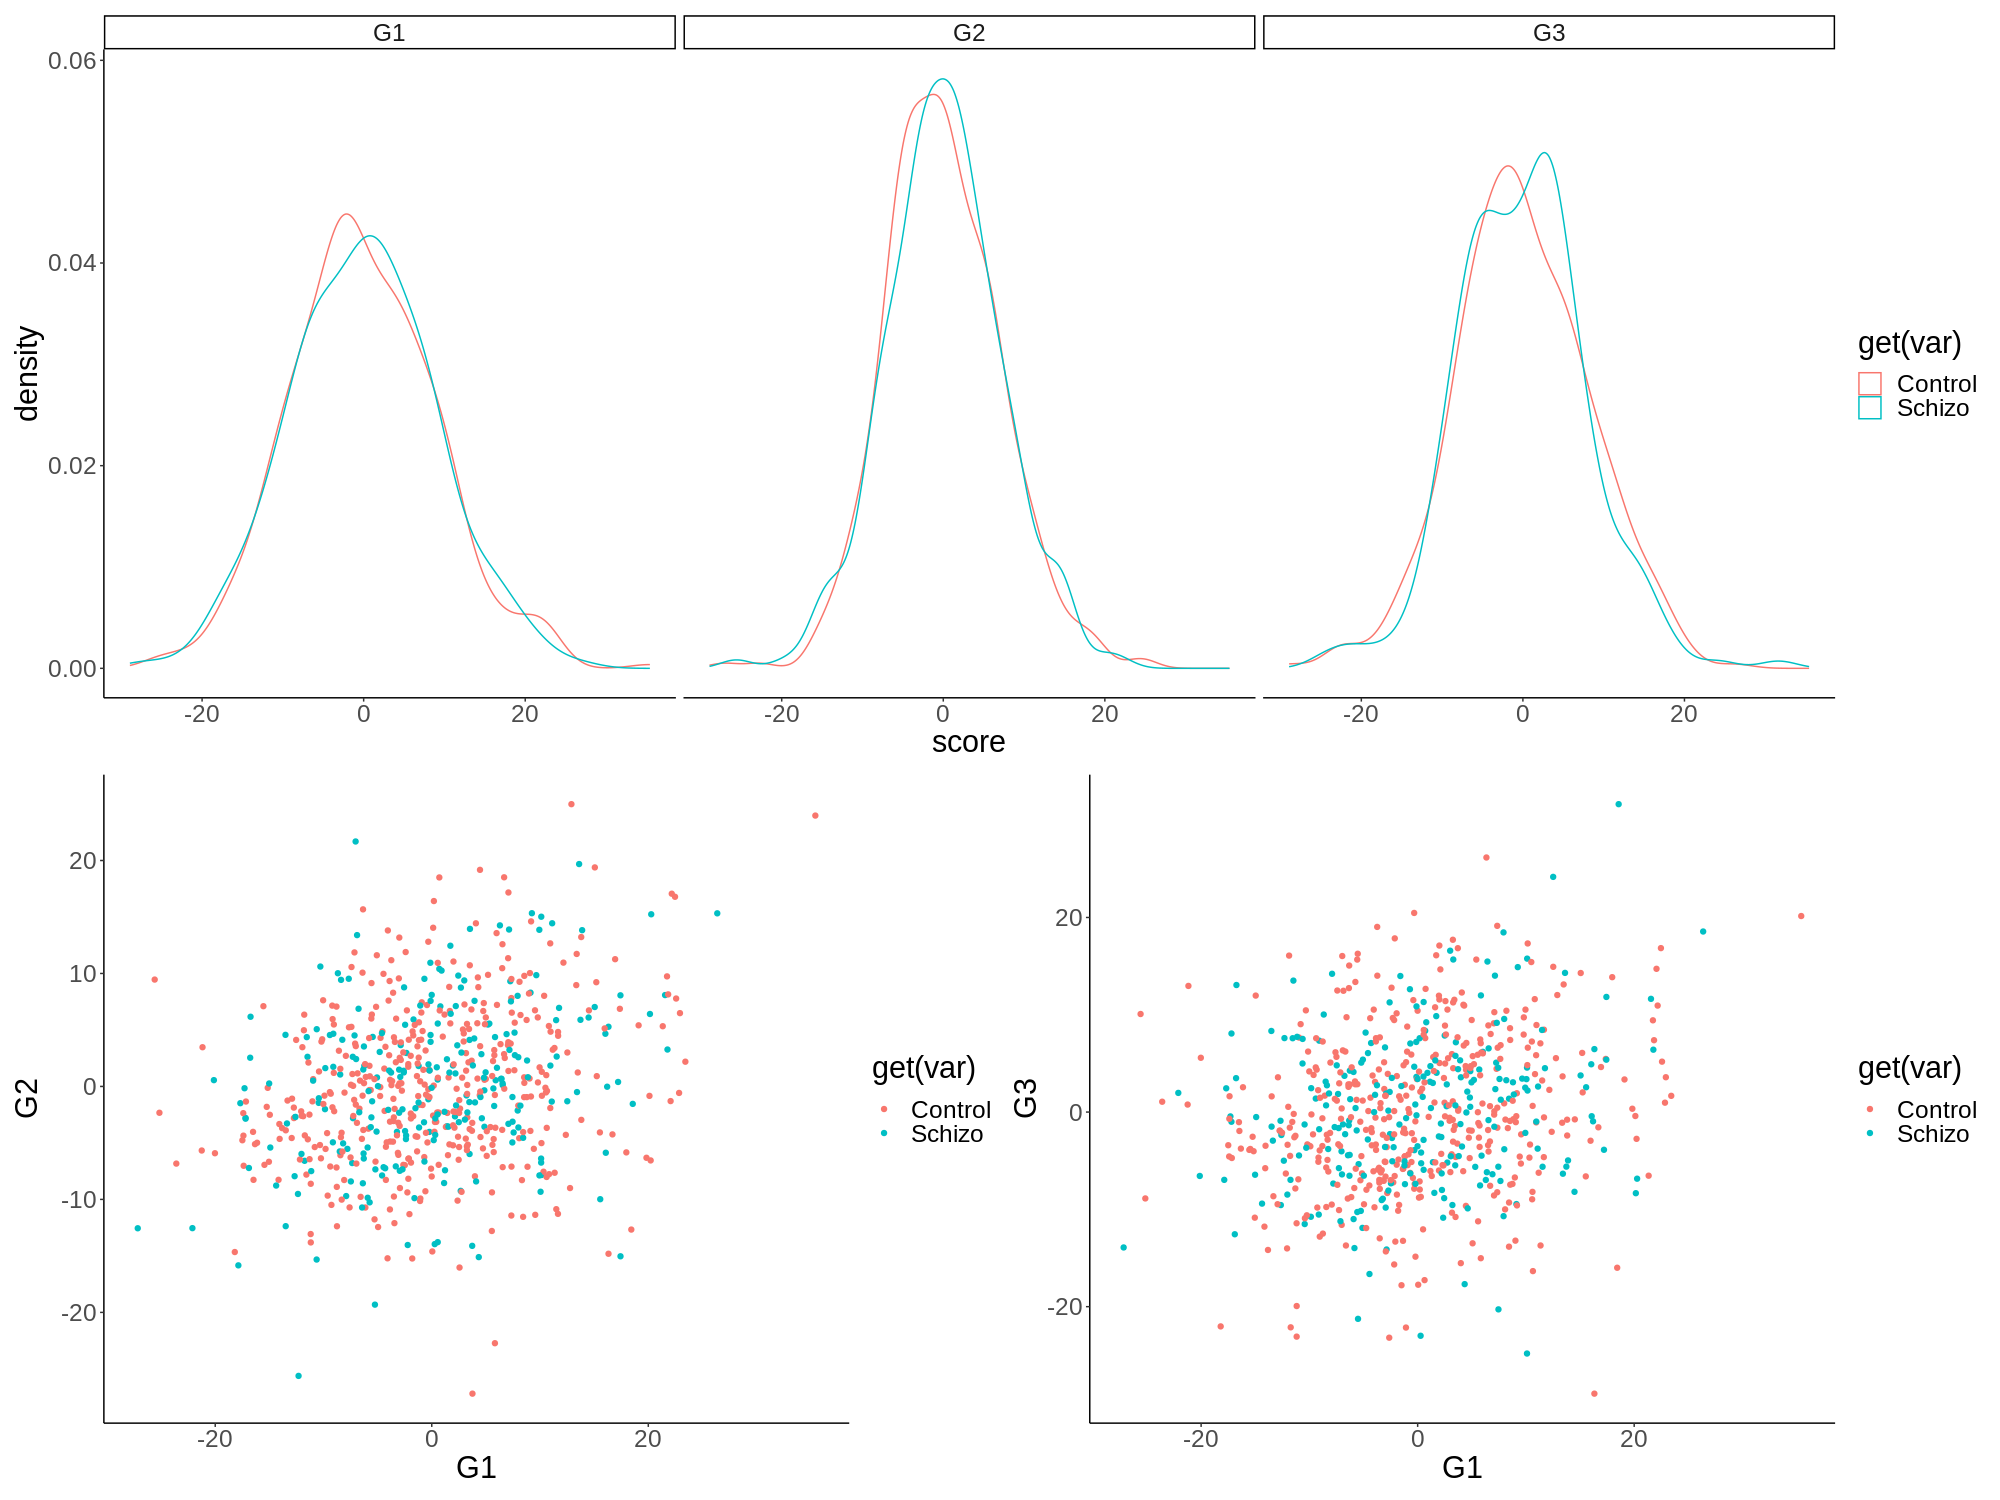

In [256]:
%%R -i exp_join -w 20 -h 15 -u in -r 100

var <- 'PrimaryDx'
# var <- 'PastSI'
# var <- 'Manner Of Death'
# var <- 'Race'
# var <- 'Age Onset Schizo'

exp_join <- exp_join %>% filter(PrimaryDx!='Substance')

g0 <- exp_join %>% 
pivot_longer(G1:G3, names_to='G', values_to='score') %>% 
ggplot(aes(x=score)) + 
geom_density(aes(color=get(var))) + 
facet_wrap(~G) + 
theme_classic()

g1 <- exp_join %>% 
ggplot(aes(G1,G2)) + 
geom_point(aes(color=get(var))) + 
theme_classic()

g2 <- exp_join %>% 
ggplot(aes(G1,G3)) + 
geom_point(aes(color=get(var))) + 
theme_classic()

(g0 / (g1 + g2)) & theme(text=element_text(size=22))